In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

# Download NLTK data files
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/jafarian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /users/jafarian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [63]:
# Load the dataset
df = pd.read_csv('Reviews.csv')

# Display the first few rows
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [64]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


In [65]:
print(len(df))

568454


In [66]:
# Drop rows with missing values in 'Text' or 'Score' columns
df = df.dropna(subset=['Text', 'Score'])

# Reset index after dropping rows
df = df.reset_index(drop=True)


In [67]:
print(len(df))

568454


In [68]:
# Remove duplicate reviews based on 'UserId', 'ProfileName', 'Time', and 'Text'
df = df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])

# Reset index
df = df.reset_index(drop=True)



In [69]:
print(len(df))

393933


In [70]:
def map_score_to_sentiment(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    elif score in [4, 5]:
        return 2  # Positive

# Apply the mapping function
df['Sentiment'] = df['Score'].apply(map_score_to_sentiment)


# Remove 200,000 rows from the Positive sentiment (Sentiment == 2)
positive_reviews = df[df['Sentiment'] == 2]
positive_reviews_sample = positive_reviews.sample(n=80000, random_state=42)  # Retain 100,000 rows

negative_reviews = df[df['Sentiment'] == 0]
neutral_reviews = df[df['Sentiment'] == 1]

# Combine to create a balanced dataset
df = pd.concat([positive_reviews_sample, negative_reviews, neutral_reviews])

# Shuffle the data to mix Positive, Negative, and Neutral examples
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [71]:
print(len(df))

166877


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text preprocessing
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

In [73]:
# Display a few examples
df[['Text', 'Cleaned_Text', 'Sentiment']].head()


,Text,Cleaned_Text,Sentiment
0,With the consistency of Alka-Seltzer and that ...,with the consistency of alkaseltzer and that a...,0
1,"At first try, I was tempted to give it a sligh...",at first try i was tempted to give it a slight...,1
2,I come from Japan and am super picky with the ...,i come from japan and am super picky with the ...,2
3,"Even though I am not a soup person, Amy's has ...",even though i am not a soup person amys has ma...,2
4,The toy seems pretty durable which is a big wi...,the toy seems pretty durable which is a big wi...,2


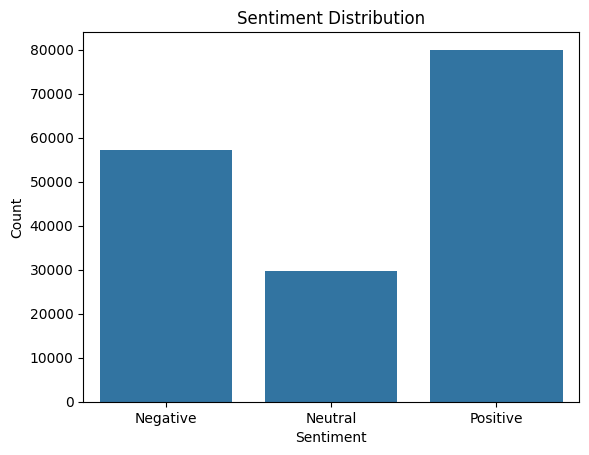

Sentiment counts:
Sentiment
2    80000
0    57108
1    29769
Name: count, dtype: int64


In [74]:
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()


# Calculate the count of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Print the counts
print(f"Sentiment counts:\n{sentiment_counts}")

In [ ]:
# Define features and labels
X = df['Cleaned_Text']
y = df['Sentiment']

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)


In [76]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=160):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [77]:
# Create datasets
train_dataset = ReviewDataset(X_train, y_train, tokenizer)
val_dataset = ReviewDataset(X_val, y_val, tokenizer)

# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [78]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # Negative, Neutral, Positive
)

# Move model to device
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Number of training epochs
epochs = 3

# Total number of training steps
total_steps = len(train_loader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [80]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


In [ ]:
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )
    
    val_acc, val_loss = eval_model(
        model,
        val_loader,
        device
    )
    
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')
    print()
    
    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)


Epoch 1/3
----------
Train loss: 0.4625, accuracy: 0.8090
Validation loss: 0.4144, accuracy: 0.8257

Epoch 2/3
----------
Train loss: 0.3493, accuracy: 0.8577
Validation loss: 0.4188, accuracy: 0.8289

Epoch 3/3
----------
Train loss: 0.2842, accuracy: 0.8862
Validation loss: 0.4523, accuracy: 0.8272



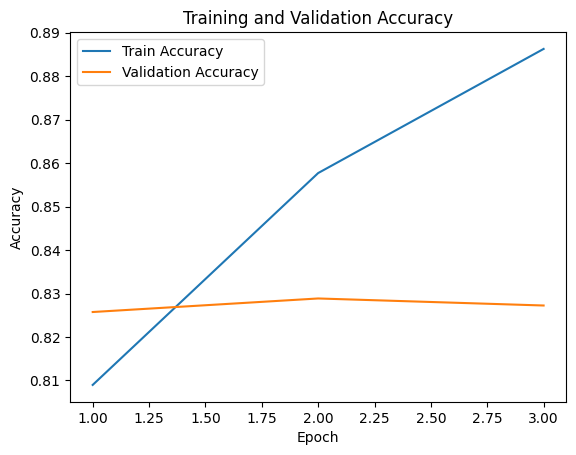

In [82]:
plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, epochs + 1), history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [83]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            _, preds = torch.max(probs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            real_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(real_labels)


y_pred, y_true = get_predictions(model, val_loader)


In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83      5711
     Neutral       0.58      0.58      0.58      2977
    Positive       0.91      0.92      0.91      8000

    accuracy                           0.83     16688
   macro avg       0.78      0.78      0.78     16688
weighted avg       0.83      0.83      0.83     16688



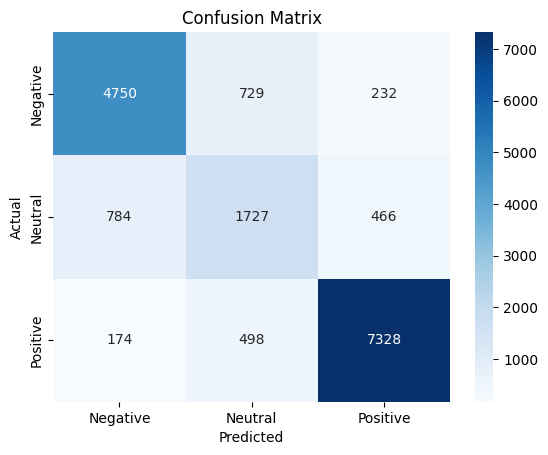

In [85]:
conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [86]:
# Save the trained model
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')


('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json')

In [87]:
def predict_sentiment(text, model, tokenizer, device):
    # Preprocess text
    text = preprocess_text(text)
    
    # Tokenize input
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=160,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get model prediction
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    _, pred = torch.max(probs, dim=1)
    
    sentiment = pred.item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[sentiment]


In [88]:
# Example texts
texts = [
    "I absolutely love this product!",
    "It's okay, not the best but not the worst.",
    "I hate these shoes."
]

for text in texts:
    sentiment = predict_sentiment(text, model, tokenizer, device)
    print(f'Text: "{text}"')
    print(f'Predicted Sentiment: {sentiment}')
    print('---')


Text: "I absolutely love this product!"
Predicted Sentiment: Positive
---
Text: "It's okay, not the best but not the worst."
Predicted Sentiment: Neutral
---
Text: "I hate these shoes."
Predicted Sentiment: Negative
---


In [89]:
# Create a DataFrame with actual and predicted sentiments
df_results = pd.DataFrame({
    'Text': X_val.reset_index(drop=True),
    'Actual_Sentiment': y_val.reset_index(drop=True),
    'Predicted_Sentiment': y_pred
})

# Map numerical sentiments to labels
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df_results['Actual_Sentiment_Label'] = df_results['Actual_Sentiment'].map(sentiment_map)
df_results['Predicted_Sentiment_Label'] = df_results['Predicted_Sentiment'].map(sentiment_map)

# Display a few examples
df_results[['Text', 'Actual_Sentiment_Label', 'Predicted_Sentiment_Label']].head()


,Text,Actual_Sentiment_Label,Predicted_Sentiment_Label
0,it claims to be great for baking and it isand ...,Positive,Positive
1,astonishing to me you can eat it oil yourself ...,Positive,Positive
2,delicious especially for a fan of sweet beef j...,Positive,Positive
3,this wholesome white bread mix by hodgson mill...,Positive,Positive
4,i have had this on my wish list for a very lon...,Positive,Positive


In [90]:
# Filter misclassified examples
misclassified = df_results[df_results['Actual_Sentiment'] != df_results['Predicted_Sentiment']]

# Display some misclassified examples
misclassified[['Text', 'Actual_Sentiment_Label', 'Predicted_Sentiment_Label']].head()


,Text,Actual_Sentiment_Label,Predicted_Sentiment_Label
5,cottom loves his bonito flakes he gets them as...,Positive,Neutral
7,legally they cant use the term organic with so...,Neutral,Negative
8,these are actually pretty good this is the onl...,Positive,Neutral
19,update on my review below was based on what i ...,Neutral,Negative
21,if you are looking at this you probably have a...,Positive,Neutral


In [92]:
df_results.to_csv('sentiment_predictions.csv', index=False)